In [230]:
import geopandas
import shapely
import rioxarray
import pathlib
import rioxarray.merge
import matplotlib

## Extend the Westport catchment
Alice would like the provided catchment to be buffered by 1km in each direction and extended North into the sea by 10km (i.e. 9km after buffering.
The Westport catchment was also found to be in WGS84 / EPSG:4326 - it was converted to EPSF:2193 for future use.

In [91]:
base_path = pathlib.Path("C:/Users/pearsonra/Documents/data/dems_for_modelling/westport/dem_2022_03_25_automatic_westport"
                         "_river_bathymetry_and_manual_orowaiti")

In [92]:
tight_catchment = geopandas.read_file(base_path / "westport_catchment.geojson")

<AxesSubplot:>

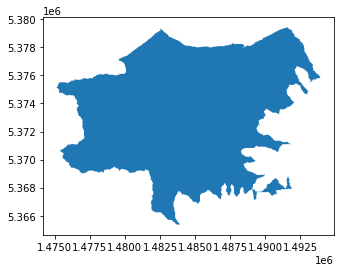

In [27]:
tight_catchment.plot()

In [35]:
bounds = tight_catchment.bounds
bounds

,minx,miny,maxx,maxy
0,1.475097e+06,5.365342e+06,1.493930e+06,5.379435e+06


In [43]:
buffer = 1000
north_buffer = 10_000
min_x = bounds['minx'].item() - buffer
min_y = bounds['miny'].item() - buffer
max_x = bounds['maxx'].item() + buffer
max_y = bounds['maxy'].item() + north_buffer

In [47]:
extended_catchment_array = [[min_x, min_y],[max_x, min_y],[max_x, max_y],[min_x, max_y]]
extended_catchment = geopandas.GeoDataFrame(geometry=[shapely.geometry.Polygon(extended_catchment_array)], crs=2193)

<AxesSubplot:>

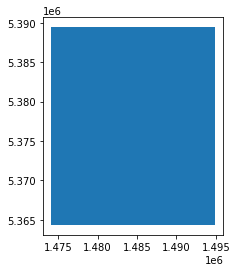

In [48]:
extended_catchment.plot()

In [94]:
extended_catchment.to_file(base_path / "westport_rectangular_catchment.geojson")

PermissionError: [WinError 32] The process cannot access the file because it is being used by another process: 'C:\\Users\\pearsonra\\Documents\\data\\dems_for_modelling\\westport\\dem_2022_03_25_automatic_westport_river_bathymetry_and_manual_orowaiti\\westport_rectangular_catchment.geojson'

## Triming the DEM to remove NN artefact 
This rectanguar catchment extends beyond the avaliable LiDAR area and as a results the DEM is produces NN artefact when interpolated where there is not tile data. 
Plan:
* Clip the rectangular catchment by the dense DEM extents on land
* Clip the rectangular catchment to keep all off land
* Combine the two halfs together

In [93]:
rectangular_catchment = geopandas.read_file(base_path / "westport_rectangular_catchment.geojson")
dense_extents = geopandas.read_file(base_path / "dem/dense_extents.geojson")
land = geopandas.read_file(base_path / "dem/51153/land.zip")

Note the at the dense_extents is a multipolygon. Ignore for now - but we may need to either merge (convex hull) or discard the tiny bit later. 

In [60]:
lidar_on_land = rectangular_catchment.clip(dense_extents)

In [61]:
offshore = rectangular_catchment.overlay(land, how='difference')

In [127]:
dem_extents = geopandas.GeoDataFrame(geometry=[shapely.ops.cascaded_union([lidar_on_land.loc[0].geometry,
                                                                           offshore.loc[0].geometry])], crs=2193)

In [128]:
dem_extents.to_file(base_path / "dem/dem_extents.geojson")

### Clip the DEM and save in the right format

In [131]:
# laod in DEM
with rioxarray.rioxarray.open_rasterio(base_path / "dem/10m_dem.nc", masked=True) as dem:
    dem.load()
dem = dem.copy(deep=True)  # Deep copy is required to ensure the opened file is properly unlocked
dem.rio.set_crs(2193);

In [133]:
# Clip DEM by extents
dem = dem.rio.clip(dem_extents.buffer(0)) # Buffer(0) as otherwise is an invalid geometry

In [134]:
# Ensure positive indexing
x = dem.x
y = dem.y
if x[0] > x[-1]:
    x = x[::-1]
if y[0] > y[-1]:
    y = y[::-1]
dem = dem.reindex(x=x, y=y)

# Save the DEM
dem.to_netcdf(base_path / "dem/10m_dem_trimmed.nc")

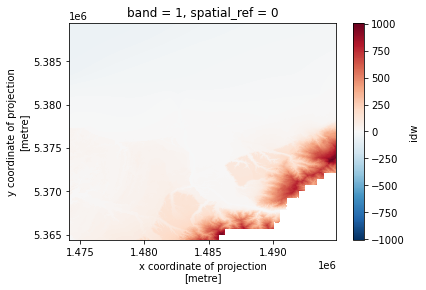

In [135]:
dem.plot()

## Read in the oroiwiti and patch
Steps:
* Read in the manaully generated Orowaiti DEM - not this was saved witht he correct CRS from 
* Clip to the provided patch region
* Place the generated DEM where there are values

In [246]:
with rioxarray.rioxarray.open_rasterio(base_path / "dem/10m_dem_trimmed.nc", masked=True) as dem:
    dem.load()
dem = dem.copy(deep=True)  # Deep copy is required to ensure the opened file is properly unlocked

In [139]:
orowaiti_catchment = geopandas.read_file(base_path / "orowaiti_patch_region.geojson")
with rioxarray.rioxarray.open_rasterio(base_path / "orowaiti_dem_2193.nc", masked=True) as orowaiti_dem:
    orowaiti_dem.load()
orowaiti_dem = orowaiti_dem.copy(deep=True)  # Deep copy is required to ensure the opened file is properly unlocked

In [157]:
orowaiti_dem_patch = orowaiti_dem.rio.clip(orowaiti_catchment.geometry)

In [248]:
orowaiti_dem_patch_aligned = dem.copy(deep=True)
orowaiti_dem_patch_aligned.data = orowaiti_dem_patch.interp(y=dem.y, x=dem.x).data

In [249]:
dem_patched_with_orowaiti = rioxarray.merge.merge_arrays([orowaiti_dem_patch_aligned, dem], method='first')

In [250]:
dem_patched_with_orowaiti.to_netcdf(base_path  / "dem/10m_dem_patched_with_orowaiti.nc")

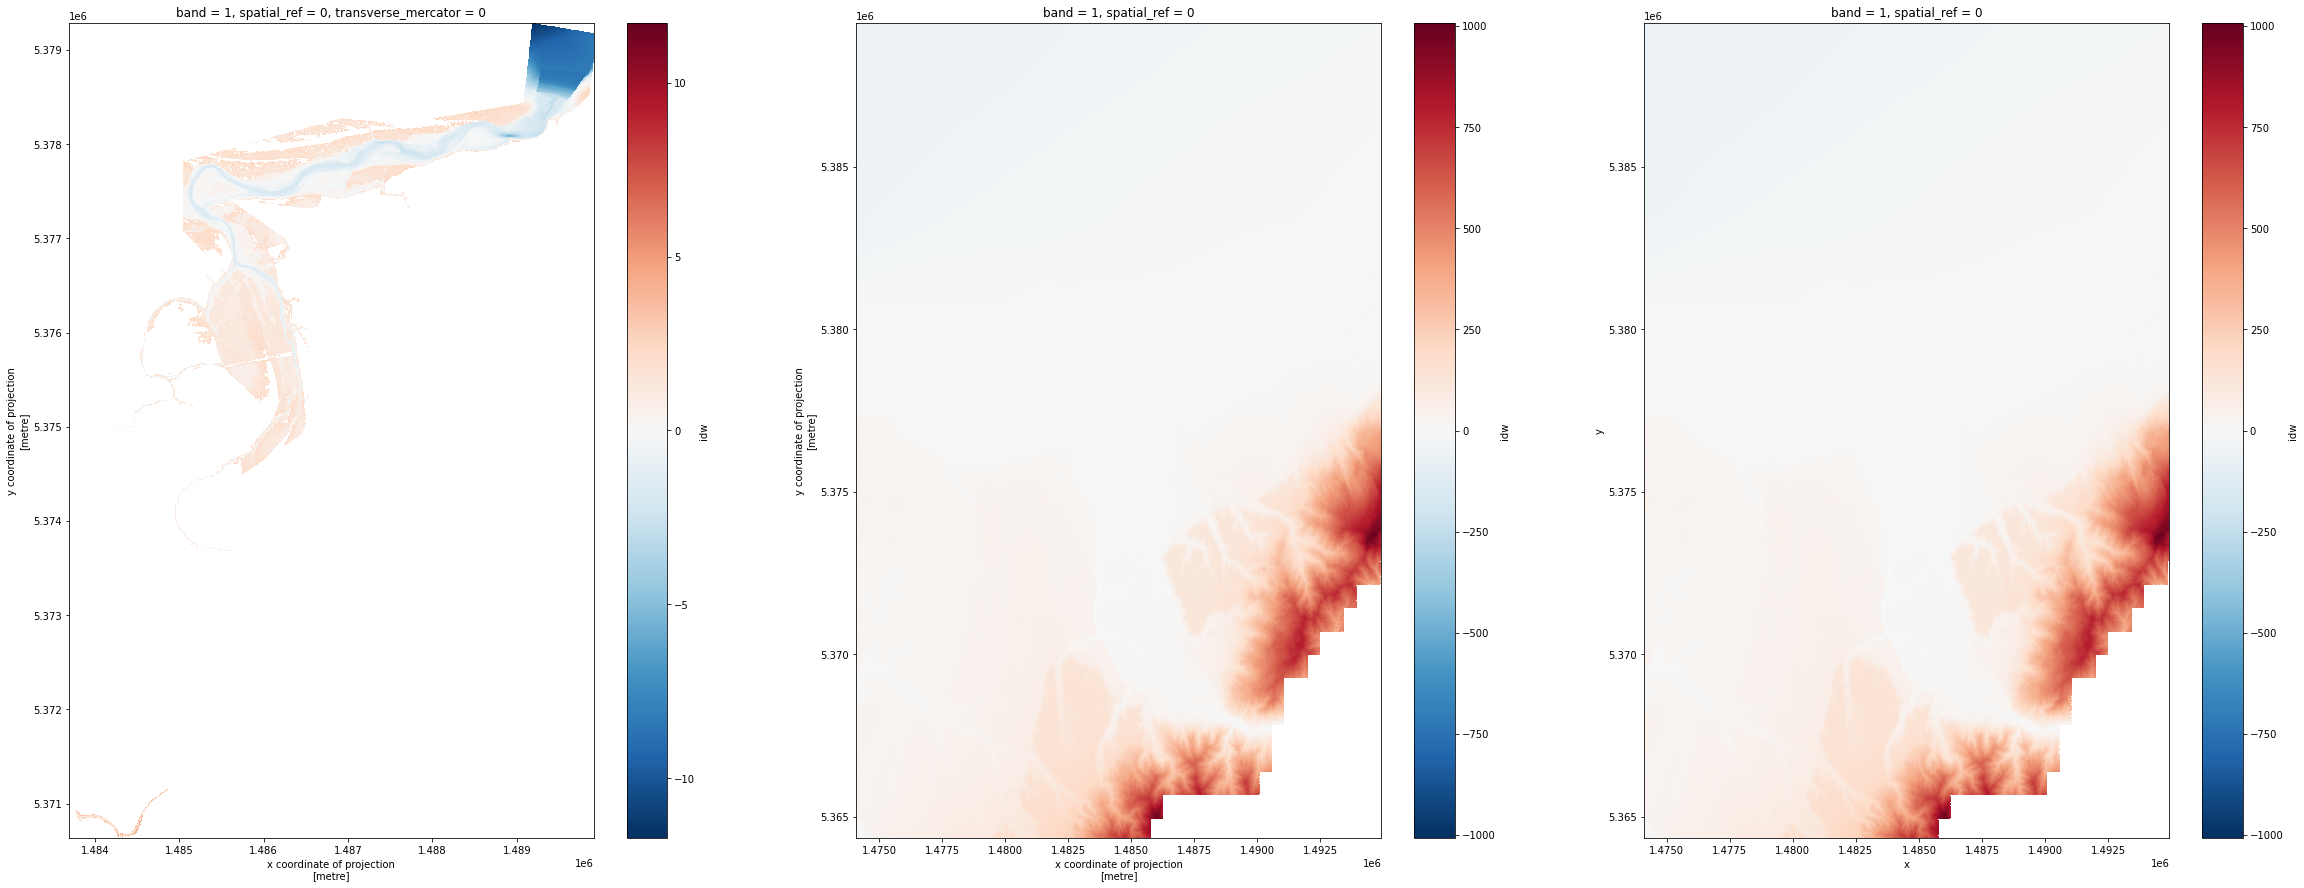

In [251]:
f, ax = matplotlib.pyplot.subplots(1, 3, figsize=(40, 15))
orowaiti_dem_patch.plot(ax=ax[0]);
dem.plot(ax=ax[1]);
dem_patched_with_orowaiti.plot(ax=ax[2]);